In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = 'breast-cancer-data'

In [3]:
# extra code to save the figures as high-res PNGs for the book
from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

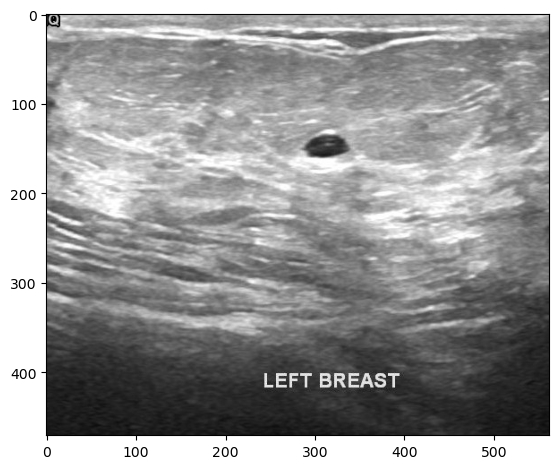

In [4]:
import matplotlib.image as mping
test_image = "breast-cancer-data/benign/benign (1).png"
img = mping.imread(test_image)
plt.imshow(img)
save_fig("sample_benign_tumor")

In [5]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=132,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1578 files belonging to 6 classes.
Using 1263 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=132,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 1578 files belonging to 6 classes.
Using 315 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['benign',
 'benign mask',
 'malignant',
 'malignant mask',
 'normal',
 'normal mask']

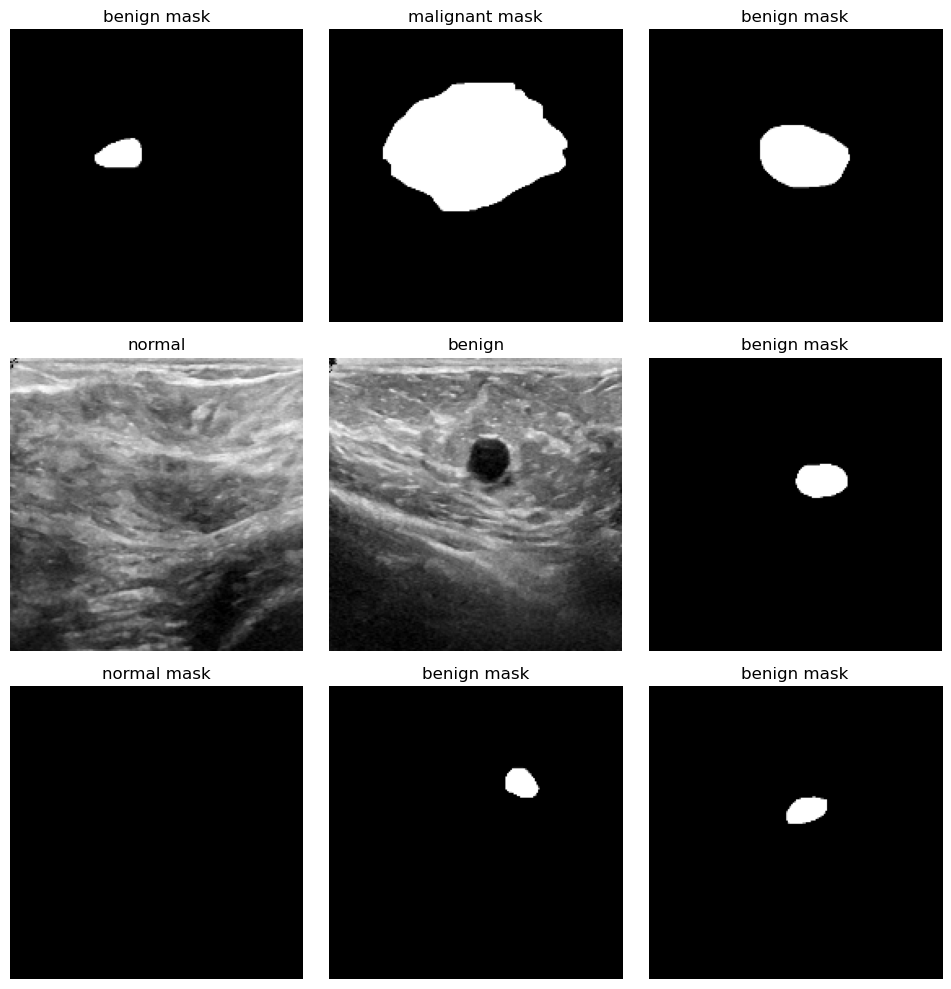

In [9]:
# Here are the first nine images from my training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range (9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        save_fig("sample_training_images")

In [10]:
# manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [11]:
# configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Standadrize the values in the [0,1] RGB channel range by using tf.keras.Rescaling
normailization_layers = layers.Rescaling(1./255)

In [14]:
# reduce overfitting through data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

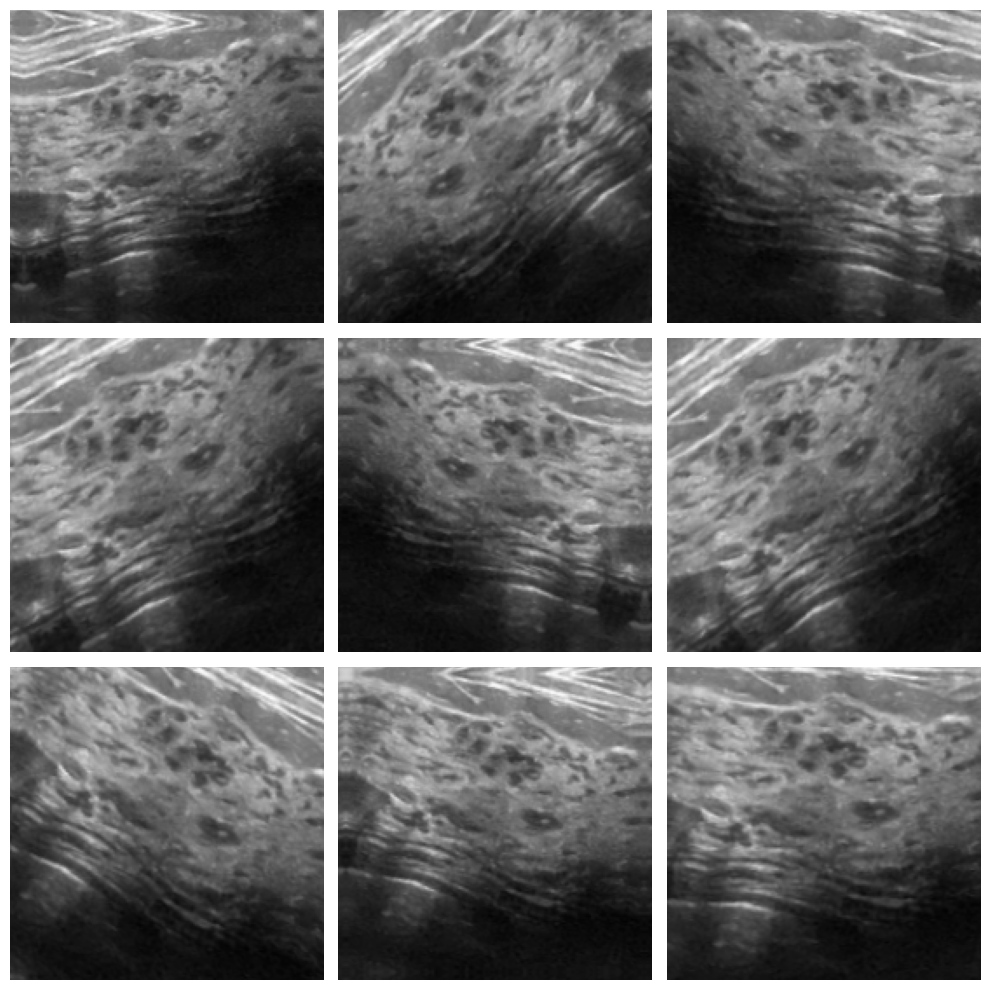

In [15]:
# visualize a few augmented examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')
        save_fig("sample_augmented_images")

In [16]:
# intoduce Dropout in the network to help reduce overfitting further
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, name="outputs")
])

In [17]:
# compile and train the model
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [19]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
40/40 [==============================] - 64s 1s/step - loss: 0.9880 - accuracy: 0.5788 - val_loss: 0.6736 - val_accuracy: 0.7397
Epoch 2/15
40/40 [==============================] - 50s 1s/step - loss: 0.7316 - accuracy: 0.6880 - val_loss: 0.6537 - val_accuracy: 0.7111
Epoch 3/15
40/40 [==============================] - 51s 1s/step - loss: 0.6500 - accuracy: 0.7205 - val_loss: 0.6097 - val_accuracy: 0.7587
Epoch 4/15
40/40 [==============================] - 56s 1s/step - loss: 0.5961 - accuracy: 0.7490 - val_loss: 0.5531 - val_accuracy: 0.7778
Epoch 5/15
40/40 [==============================] - 55s 1s/step - loss: 0.5710 - accuracy: 0.7641 - val_loss: 0.6151 - val_accuracy: 0.7619
Epoch 6/15
40/40 [==============================] - 57s 1s/step - loss: 0.5504 - accuracy: 0.7688 - val_loss: 0.6156 - val_accuracy: 0.7524
Epoch 7/15
40/40 [==============================] - 61s 2s/step - loss: 0.5255 - accuracy: 0.7736 - val_loss: 0.5667 - val_accuracy: 0.7429
Epoch 8/15
40/40 [==

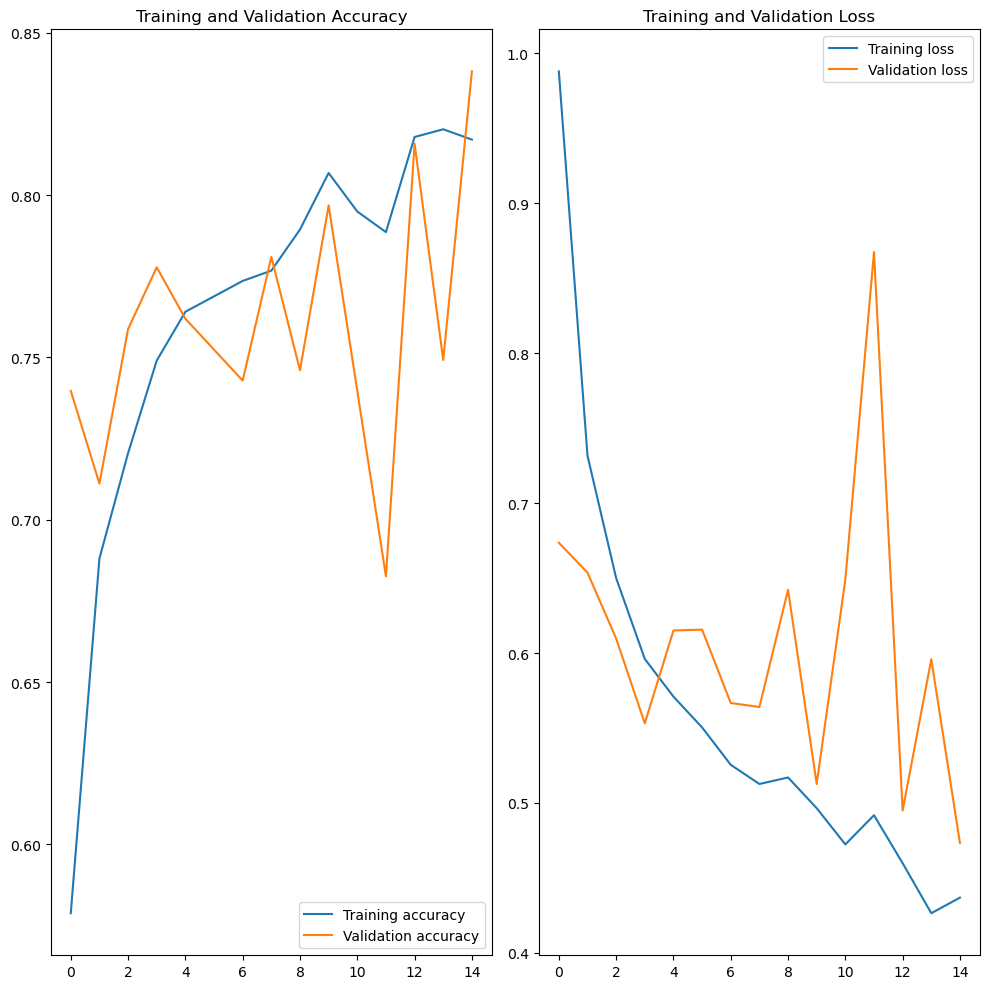

In [20]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
save_fig("training_and_validation_accuracy_and_loss_2")
plt.show()

In [21]:
# predict on new data
img = tf.keras.utils.load_img(
    "breast-cancer-data/test_3.png", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 318ms/step
This image most likely belongs to malignant with a 94.86 percent confidence.


In [22]:
# convert the model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save the model
with open('breast_cancer_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ojare\AppData\Local\Temp\tmpyuo0pgqg\assets


INFO:tensorflow:Assets written to: C:\Users\ojare\AppData\Local\Temp\tmpyuo0pgqg\assets


In [24]:
# run the tensorflow lite model
TF_MODEL_FILE_PATH = 'breast_cancer_model.tflite'
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [25]:
# print the signature of the converted model to get names of the inputs and outputs
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_input'], 'outputs': ['outputs']}}

In [26]:
# test the loaded model
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [27]:
# make predictions using tensorflow lite model
predictions_lite = classify_lite(sequential_input=img_array)["outputs"]
score_lite = tf.nn.softmax(predictions_lite)

In [28]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to malignant with a 94.86 percent confidence.


In [31]:
print(np.max(np.abs(predictions - predictions_lite)))

1.9073486e-06


In [29]:
import os
import json
import tempfile
import requests

In [30]:
MODEL_DIR = "ML/models/breast_cancer_model"
version = '1'
export_path = os.path.join(MODEL_DIR, str(version))

# save the model
model.save(export_path, save_format='tf')
print('\nexport_path = {}'.format(export_path))
!dir {export_path}

INFO:tensorflow:Assets written to: ML/models/breast_cancer_model\1\assets


INFO:tensorflow:Assets written to: ML/models/breast_cancer_model\1\assets



export_path = ML/models/breast_cancer_model\1


Invalid switch - "models".


In [32]:
model.save("breast_cancer_classifier.h5")